**Реализация ULMFit для [Twitter US Sentiment Data](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)**

In [0]:
import sklearn
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd 
import sklearn
from sklearn.model_selection import train_test_split 
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

## Downloading the dataset 

In [0]:
data = pd.read_csv("../twitter-airline-sentiment/Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Finding & removing columns that are mostly empty 

In [0]:
(len(data)-data.count())/len(data)

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [0]:
## Removing empty columns 
del data['airline_sentiment_gold']
del data['negativereason_gold']
del data['tweet_coord']

In [0]:
## Count comments corresponding to negative/neutral/positive 
sentiment_count = data['airline_sentiment'].value_counts()
print(sentiment_count)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


Text(0.5,1,'Sentiment v Sentiment count ')

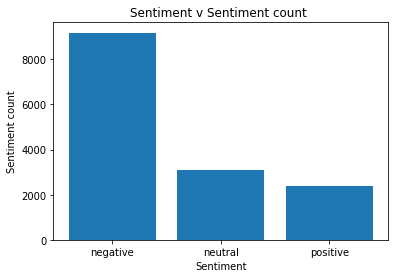

In [0]:
## Plot sentiments v.s Number of each sentiment 
plt.bar([1,2,3], sentiment_count)
plt.xticks([1,2,3], ['negative', 'neutral', 'positive'])
plt.ylabel('Sentiment count')
plt.xlabel('Sentiment')
plt.title('Sentiment v Sentiment count ')

## Illustrating the most common words used in negative, positive and neutral tweets 

In [0]:
!pip install wordcloud

    100% |████████████████████████████████| 163kB 3.8MB/s ta 0:00:01
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
from wordcloud import WordCloud, STOPWORDS

In [0]:
## From negative sentiments, make wordcloud of most common words 
## removing words that are part of the website, removing words that are twitterhandles, removing words that are RT
df = data[data['airline_sentiment']=='negative']
neg_reasons = ' '.join(df['text'])
cleaned_words = ' '.join([word for word in neg_reasons.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])

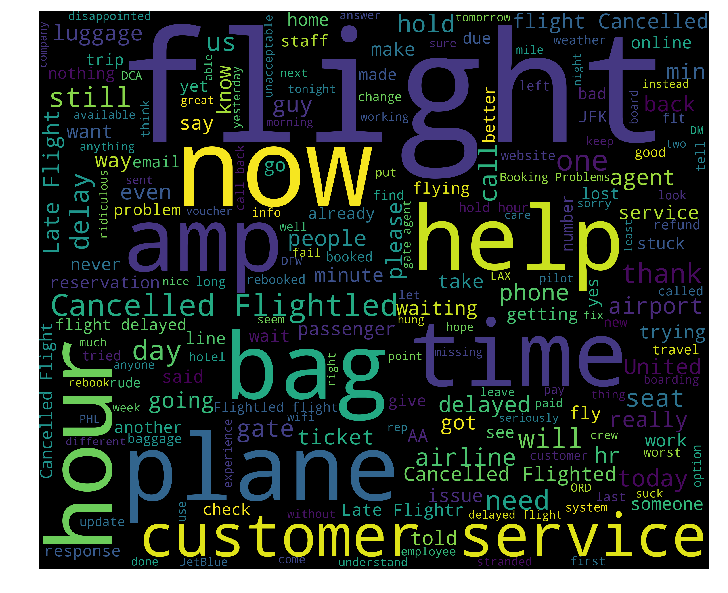

In [0]:
## wordcloud for negative sentiments
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_words)


plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [0]:
## From positive sentiments, 
df_pos = data[data['airline_sentiment']=='positive']
pos_reasons = ' '.join(df_pos['text'])
cleaned_words_pos = ' '.join([word for word in pos_reasons.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])

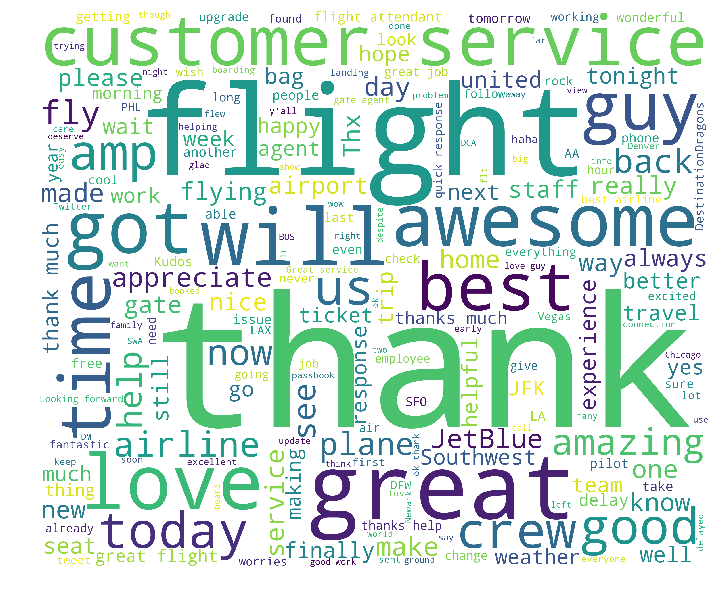

In [0]:
## wordcloud for positive sentiment 
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_words_pos)


plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [0]:
# Airline  
print(data['airline'].value_counts())

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


In [0]:
def plot(index, sentiment_count, airline):
    plt.bar(index, sentiment_count)
    plt.xticks(index, ['negative', 'neutral', 'positive'])
    plt.ylabel('Sentiment count for' + airline)
    plt.xlabel('Sentiment')
    plt.title('Sentiment v Sentiment count for' + airline)

The representation below gives you a good overview of which airlines receive more negative reviews 

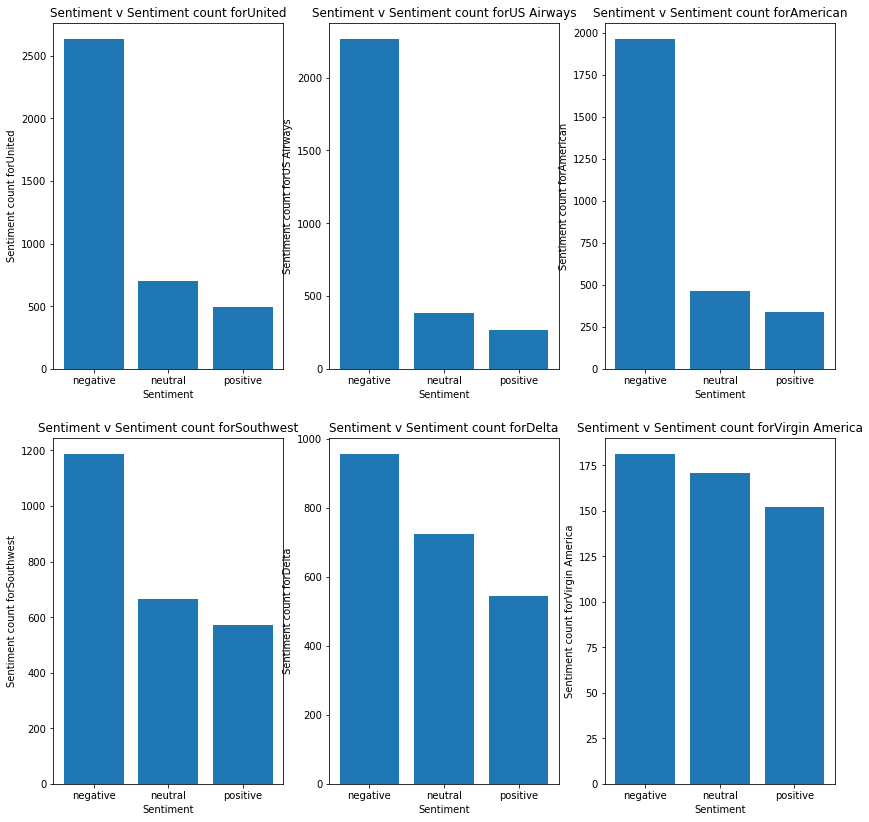

In [0]:
## Sort negative positive and neutral comments by airlines 
def sort_airlines(airline): 
    df = data[data['airline']==airline]
    sentiment_count = df['airline_sentiment'].value_counts()
    plot([1,2,3], sentiment_count, airline)

plt.figure(3, figsize=(14,14))
plt.subplot(231)
sort_airlines('United')
plt.subplot(232)
sort_airlines('US Airways')
plt.subplot(233)
sort_airlines('American')
plt.subplot(234)
sort_airlines('Southwest')
plt.subplot(235)
sort_airlines('Delta')
plt.subplot(236)
sort_airlines('Virgin America')


With negative comments, we want to know the reasons why which is more constructive feedback for the airlines to improve


## Data Preprocessing 


In [0]:
!pip install -q nltk.corpus

In [0]:
import re 
import nltk
from nltk.corpus import stopwords 
import html 
!pip install spacy 
!python -m spacy download en 
import spacy 


In [0]:
# Removing twitter handles 
def remove_pattern(input_txt, pattern): 
    r = re.findall(pattern, input_txt)
    for i in r: 
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [0]:
# removes http, special characters, numbers, punctuation
def clean_data(data): 
    data = data.str.replace('http?://[A-Za-z0-9./]+', " ")
    data = data.str.replace("[^a-zA-Z#]", " ")
    # removes short words
    data = data.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
    return data

In [0]:
data['clean_tweets'] = np.vectorize(remove_pattern)(data['text'], "@[\w]*")

In [0]:
data['clean_tweets'] = clean_data(data['clean_tweets'])
print(data['clean_tweets'])

0                                                What said
1                  plus added commercials experience tacky
2              didn today Must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                       really thing about
5        seriously would flight seats that didn have th...
6                         nearly every time this worm away
7        Really missed prime opportunity Without Hats p...
8                                                Well didn
9                          amazing arrived hour early good
10       know that suicide second leading cause death a...
11       pretty graphics much better than minimal icono...
12       This such great deal Already thinking about tr...
13       flying your #fabulous #Seductive skies again t...
14                                                  Thanks
15                                          schedule still
16       excited first cross country flight heard nothi.

In [0]:
# Tokenization 
def tokenize(data): 
    data = data.apply(lambda x : x.split())
    return data

In [0]:
data['token'] = tokenize(data['clean_tweets'])
print(data['token'])

0                                             [What, said]
1            [plus, added, commercials, experience, tacky]
2        [didn, today, Must, mean, need, take, another,...
3        [really, aggressive, blast, obnoxious, enterta...
4                                   [really, thing, about]
5        [seriously, would, flight, seats, that, didn, ...
6                  [nearly, every, time, this, worm, away]
7        [Really, missed, prime, opportunity, Without, ...
8                                             [Well, didn]
9                    [amazing, arrived, hour, early, good]
10       [know, that, suicide, second, leading, cause, ...
11       [pretty, graphics, much, better, than, minimal...
12       [This, such, great, deal, Already, thinking, a...
13       [flying, your, #fabulous, #Seductive, skies, a...
14                                                [Thanks]
15                                       [schedule, still]
16       [excited, first, cross, country, flight, heard.

In [0]:
from nltk.stem.porter import * 
# converting words to stem word 
def stemming(tokenized_tweet): 
    stemmer = PorterStemmer() 
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
    for i in range(len(tokenized_tweet)): 
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    return tokenized_tweet
    

In [0]:
data['stemming'] = stemming(data['token'])
data['stemming']

0                                                what said
1                             plu ad commerci experi tacki
2                didn today must mean need take anoth trip
3        realli aggress blast obnoxi entertain your gue...
4                                       realli thing about
5        serious would flight seat that didn have thi p...
6                          nearli everi time thi worm away
7        realli miss prime opportun without hat parodi ...
8                                                well didn
9                               amaz arriv hour earli good
10       know that suicid second lead caus death among ...
11       pretti graphic much better than minim iconographi
12       thi such great deal alreadi think about trip h...
13       fli your #fabul #seduct sky again take #stress...
14                                                   thank
15                                           schedul still
16       excit first cross countri flight heard noth gr.

In [0]:
# Understanding impact of Hashtags on tweet sentiments 
# method to collect hashtags 
def hashtag_extract(x): 
    hashtags = [] 
    for i in x: 
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags 

In [0]:
HT_neg = hashtag_extract(data['stemming'][data['airline_sentiment']=='negative'])
HT_pos = hashtag_extract(data['stemming'][data['airline_sentiment']=='positive'])
HT_neu = hashtag_extract(data['stemming'][data['airline_sentiment']=='neutral'])

HT_neg = sum(HT_neg, [])
HT_pos = sum(HT_pos, [])
HT_neu = sum(HT_neu, [])

In [0]:
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
def plot_hashtags(HT): 
    a = nltk.FreqDist(HT)
    d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})
    # select top 10 hashtags 
    d = d.nlargest(columns='Count', n=10)
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d, x='Hashtag', y='Count')
    ax.set(ylabel='Count')
    plt.show()

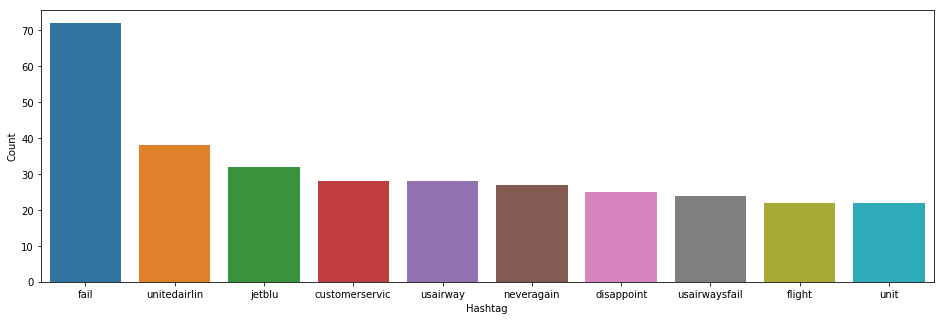

In [0]:
plot_hashtags(HT_neg)

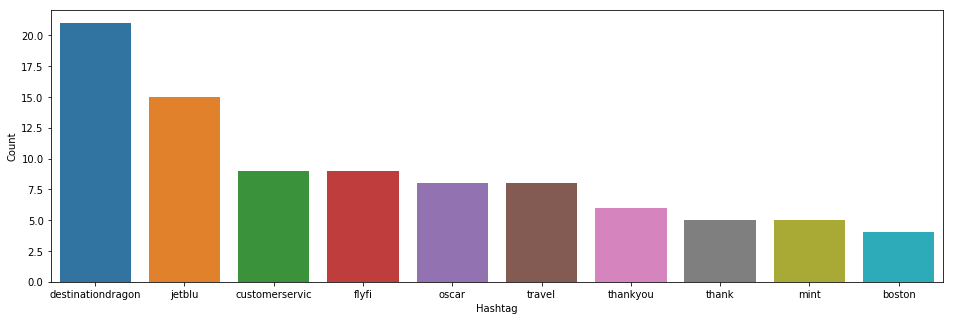

In [0]:
plot_hashtags(HT_pos)

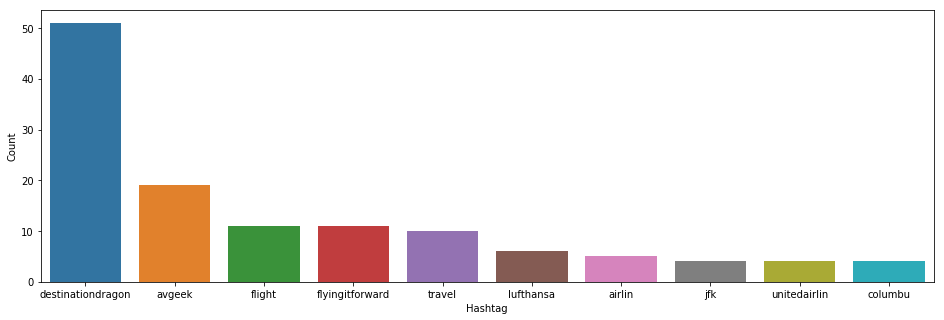

In [0]:
plot_hashtags(HT_neu)

The hashtags between positive and negative tweets might not be too informative but let's keep them for now.

In [0]:
# randomize dataset
np.random.seed(42)
data.sample(frac=1)

# data for classification model
df = data[['airline_sentiment', 'text']]
train, valid = train_test_split(df,
                                stratify=df['airline_sentiment'],
                                test_size = 0.1, random_state=43)


In [0]:
# data for language model 
col_names = ['labels', 'text']
df_lm = pd.DataFrame({'text': data['text'], 'labels': [0]*len(text_df)}, columns=col_names)
    
train_lm, valid_lm = train_test_split(df_lm, 
                                test_size = 0.1, random_state=43)



## Implementing ULMFit 

In [0]:
# language model 
data_lm = TextLMDataBunch.from_df(train_df = train_lm, valid_df = valid_lm, path="")

# classification model 
data_clas = TextClasDataBunch.from_df(path="", train_df = train, valid_df = valid, vocab=data_lm.train_ds.vocab, bs=32 )


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,5.219501,4.289021,0.224826


In [0]:
# save learner 
learn.save_encoder('ft_enc')

# unfreeze
learn.unfreeze()
lr = 1e-2

# perform and plot to find optimal learning rate 
learn.lr_find(lr/1000)


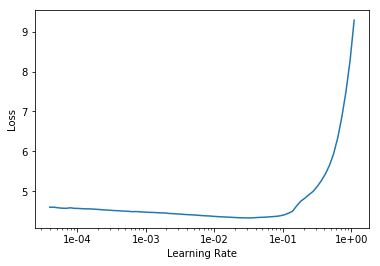

In [0]:
learn.recorder.plot()
learn.save_encoder('ft_enc2')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc2')
learn.lr_find()

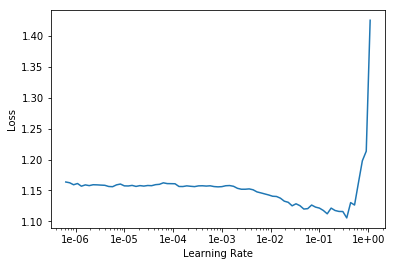

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy
1,0.911236,0.915569,0.627049
